<a href="https://colab.research.google.com/github/gonzalo-marrero/milky_way_orbital_dynamics/blob/main/milky_way_orbital_dyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =========================
# CELDA 1: INSTALACIÓN DE PAQUETES
# =========================
!pip install gala astroquery astropy matplotlib numpy

# =========================
# CELDA 2: IMPORTACIÓN DE LIBRERÍAS
# =========================
# Astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np

# Gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# Para visualización inline en Colab
%matplotlib inline


In [10]:
# Datos de GAIA
gaia_data = QTable.read('data/gaia_data.fits')
gaia_data[:4]  # Revisar primeras filas


ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float64,float32,float32,float32
256.8370985186671,46.5081010273448,10.770964834345387,-19.76657104695835,55.92605676622464,-17.673072044811907,12.956912994384766,14.192928314208984,11.859498023986816
129.45826809010867,-6.806694022293258,41.081670013380716,-297.34595349374183,43.83424795415093,35.53814452290586,6.576352119445801,6.931065082550049,6.111272811889648
2.317856723637118,9.00699655780345,17.824765284426462,-171.8278607514459,-1083.8740928197751,-148.91780163518774,13.119074821472168,13.968703269958496,12.223302841186523
330.41287472805976,51.88897801553169,13.0756133009657,-85.30745872006916,-34.23366534215265,-28.726469345049587,12.101919174194336,13.05264949798584,11.149785995483398


In [13]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
print("Distancia mínima:", dist.min())
print("Distancia máxima:", dist.max())

# Crear objeto SkyCoord en referencia ICRS
c = coord.SkyCoord(
    ra=gaia_data['ra'],
    dec=gaia_data['dec'],
    distance=dist,
    pm_ra_cosdec=gaia_data['pmra'],
    pm_dec=gaia_data['pmdec'],
    radial_velocity=gaia_data['radial_velocity']
)

print("Primeras 4 coordenadas SkyCoord:")
print(c[:4])

# Transformación a coordenadas galácticas
print("Coordenadas galácticas:")
print(c.galactic[:4])

# Transformación a Galactocéntrico
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.1*u.kpc))
print("Primeras coordenadas Galactocéntricas:")
print(galcen[:4])


Distancia mínima: 8.799092905248134 pc
Distancia máxima: 99.99985291958117 pc
Primeras 4 coordenadas SkyCoord:
<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(256.83709852, 46.50810103, 92.84219338),
     (129.45826809, -6.80669402, 24.3417563 ),
     (  2.31785672,  9.00699656, 56.1017205 ),
     (330.41287473, 51.88897802, 76.47824825)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( -19.76657105,    55.92605677,  -17.67307204),
     (-297.34595349,    43.83424795,   35.53814452),
     (-171.82786075, -1083.87409282, -148.91780164),
     ( -85.30745872,   -34.23366534,  -28.72646935)]>
Coordenadas galácticas:
<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [( 72.32926334,  36.8367097 , 92.84219338),
     (232.07542475,  19.9763116 , 24.3417563 ),
     (105.68646983, -52.44715126, 56.1017205 ),
     ( 98.28701089,  -2.66800849, 76.47824825)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(  55.1303555

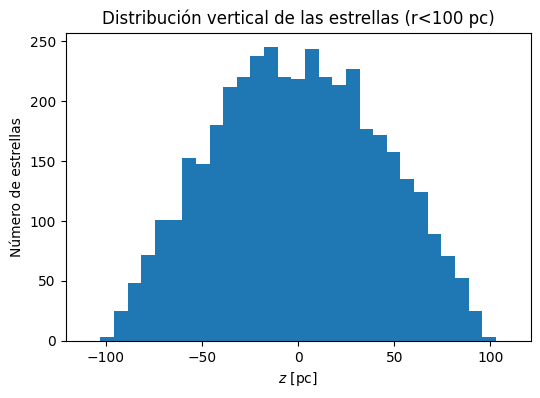

In [15]:
# Seleccionamos solo estrellas dentro de 100 pc (como en la práctica)
mask_100pc = dist < 100*u.pc
z_vals = galcen.z.value[mask_100pc]

plt.figure(figsize=(6,4))
plt.hist(z_vals, bins=np.linspace(-110, 110, 32))
plt.xlabel('$z$ [pc]')
plt.ylabel('Número de estrellas')
plt.title('Distribución vertical de las estrellas (r<100 pc)')
plt.show()


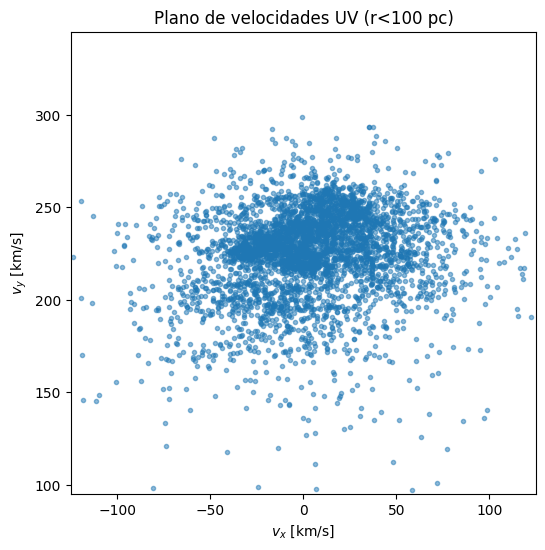

In [17]:
# Filtramos solo estrellas dentro de 100 pc
mask_100pc = dist < 100*u.pc
vx_vals = galcen.v_x.value[mask_100pc]
vy_vals = galcen.v_y.value[mask_100pc]

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(vx_vals, vy_vals, '.', alpha=0.5)

# Centrado en la velocidad circular solar ~220 km/s
ax.set_xlim(-125, 125)
ax.set_ylim(220-125, 220+125)

ax.set_xlabel('$v_x$ [km/s]')
ax.set_ylabel('$v_y$ [km/s]')
ax.set_title('Plano de velocidades UV (r<100 pc)')

plt.show()


Text(0, 0.5, '$M_G$')

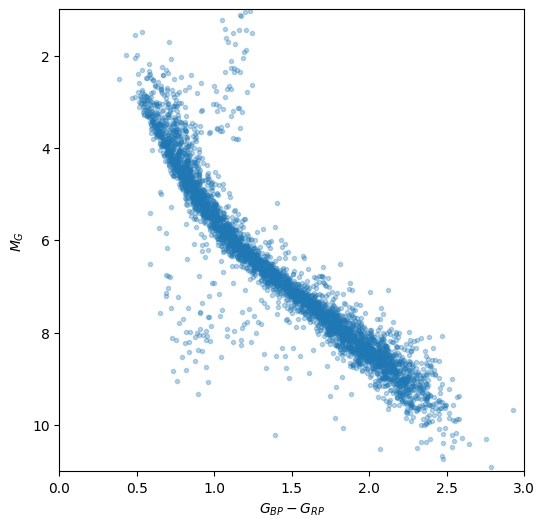

In [18]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(BP_RP.value, M_G.value,
        marker='.', linestyle='none', alpha=0.3)
ax.set_xlim(0, 3)
ax.set_ylim(11, 1)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')


In [19]:
mask_100pc = dist < 100*u.pc
M_G_vals = M_G[mask_100pc]
BP_RP_vals = BP_RP[mask_100pc]


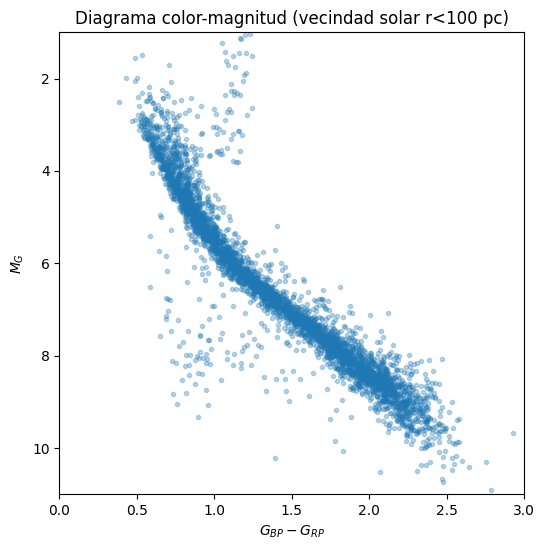

In [20]:
# Celda 6: Diagrama color-magnitud (CMD) solo para r<100pc
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(BP_RP_vals.value, M_G_vals.value, '.', alpha=0.3)
ax.set_xlim(0, 3)
ax.set_ylim(11, 1)  # Magnitudes absolutas van al revés
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
ax.set_title('Diagrama color-magnitud (vecindad solar r<100 pc)')

plt.show()


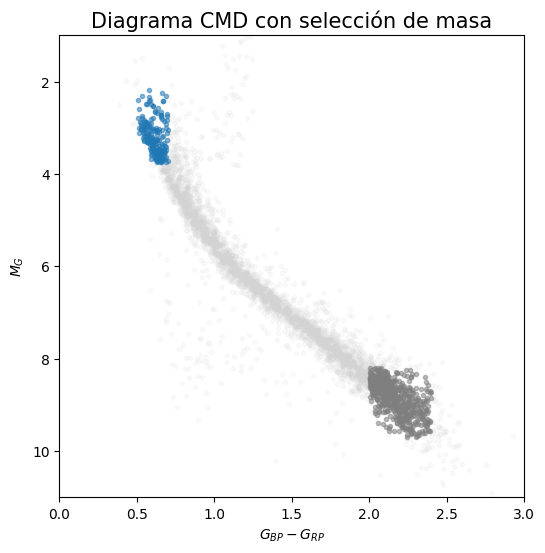

In [21]:
# Celda 7: Selección de estrellas de alta y baja masa y visualización en CMD

# Evitar errores por operaciones con NaN
np.seterr(invalid="ignore")

# Máscara para estrellas de alta masa (main sequence, jóvenes)
hi_mass_mask = ((BP_RP_vals > 0.5*u.mag) & (BP_RP_vals < 0.7*u.mag) &
                (M_G_vals > 2*u.mag) & (M_G_vals < 3.75*u.mag) &
                (np.abs(galcen.v_y[mask_100pc] - 220*u.km/u.s) < 50*u.km/u.s))

# Máscara para estrellas de baja masa (main sequence, mayores)
lo_mass_mask = ((BP_RP_vals > 2*u.mag) & (BP_RP_vals < 2.4*u.mag) &
                (M_G_vals > 8.2*u.mag) & (M_G_vals < 9.7*u.mag) &
                (np.abs(galcen.v_y[mask_100pc] - 220*u.km/u.s) < 50*u.km/u.s))

# Colores
hi_mass_color = 'tab:blue'
lo_mass_color = 'tab:grey'

# Gráfico CMD con ambas selecciones
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Todo el CMD de fondo
ax.plot(BP_RP_vals.value, M_G_vals.value, '.', alpha=0.1, color='lightgray')

# Sobreposición de alta y baja masa
for mask, color in zip([lo_mass_mask, hi_mass_mask], [lo_mass_color, hi_mass_color]):
    ax.plot(BP_RP_vals[mask].value, M_G_vals[mask].value, '.', alpha=0.5, color=color)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)
ax.set_title('Diagrama CMD con selección de masa', size=15)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

plt.show()


In [28]:
milky_way = gp.MilkyWayPotential()
milky_way

<CompositePotential disk,bulge,nucleus,halo>

In [29]:
different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
different_disk_potential

<CompositePotential disk,bulge,nucleus,halo>

In [30]:
H = gp.Hamiltonian(milky_way)

In [31]:
w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian)
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian)
w0_hi.shape, w0_lo.shape


((185,), (593,))

In [32]:
type(w0_lo)

gala.dynamics.core.PhaseSpacePosition

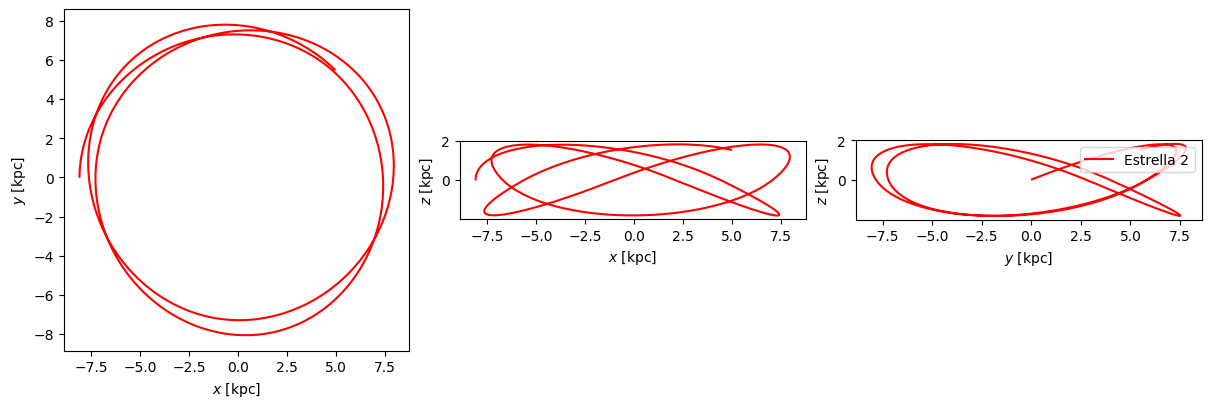

In [33]:
w0_lo1 = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian[240])
w0_lo2 = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian[296])
w0_lo3 = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian[479])
orbits_lo1 = H.integrate_orbit(w0_lo1, dt=1*u.Myr,
                              t1=0*u.Myr, t2=500*u.Myr)
orbits_lo2 = H.integrate_orbit(w0_lo2, dt=1*u.Myr,
                              t1=0*u.Myr, t2=500*u.Myr)
orbits_lo3 = H.integrate_orbit(w0_lo3, dt=1*u.Myr,
                              t1=0*u.Myr, t2=500*u.Myr)
#fig = orbits_lo1.plot(color='b', label="Estrella 1")
#plt.legend(loc="upper right")
fig = orbits_lo2.plot(color='r', label="Estrella 2")
plt.legend(loc="upper right")
#fig = orbits_lo3.plot(color='g', label="Estrella 3")
#plt.legend(loc="upper right")

In [34]:
#Declaro las variables:
nnHM=len(galcen[hi_mass_mask].v_y.value)
nnLM=len(galcen[lo_mass_mask].v_y.value)
sumvyHM=sum(galcen[hi_mass_mask].v_y.value)
sumvyLM=sum(galcen[lo_mass_mask].v_y.value)
#Velocidades promedio:
averageHighmass=sumvyHM/nnHM
averageLowmass=sumvyLM/nnLM
#Excentricidades promedio:
sumEHM=sum(galcen[hi_mass_mask].v_y.value)
sumELM=sum(galcen[hi_mass_mask].v_y.value)
#Imprimir resultados:
print('Velocidad tangencial promedio de las estrellas masivas es', '{:.2f}'.format(averageHighmass), 'km/s')
print('Velocidad tangencial promedio de las estrellas poco masivas es', '{:.2f}'.format(averageLowmass), 'km/s')
varianza=np.var(galcen[lo_mass_mask].v_y.value)
desv=np.sqrt(varianza)
desv

Velocidad tangencial promedio de las estrellas masivas es 232.02 km/s
Velocidad tangencial promedio de las estrellas poco masivas es 225.23 km/s


np.float64(20.192251759799163)

In [35]:
vStar1=galcen[lo_mass_mask].v_y.value[240]
vStar2=galcen[lo_mass_mask].v_y.value[296]
vStar3=galcen[lo_mass_mask].v_y.value[479]
vsol=220
PorStar1=((vStar1-vsol)/vsol)*100
PorStar2=((vsol-vStar2)/vsol)*100
PorStar3=((vsol-vStar3)/vsol)*100
vStar1, vStar2, vStar3, PorStar1, PorStar2, PorStar3

(np.float64(231.807730668966),
 np.float64(207.58721563416856),
 np.float64(218.24726450643752),
 np.float64(5.367150304075455),
 np.float64(5.642174711741565),
 np.float64(0.7966979516193103))

In [36]:
orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr,
                              t1=0*u.Myr, t2=500*u.Myr)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr,
                              t1=0*u.Myr, t2=500*u.Myr)

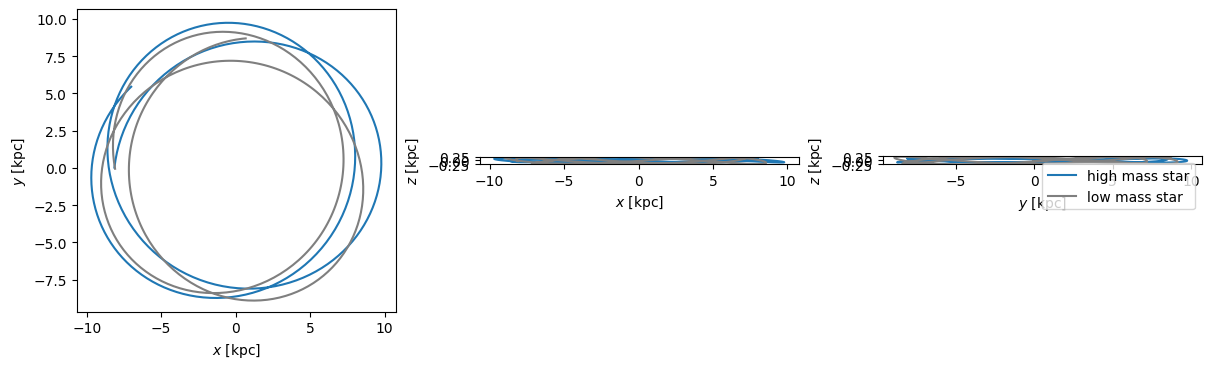

In [37]:
fig = orbits_hi[:, 0].plot(color=hi_mass_color, label="high mass star")
_ = orbits_lo[:, 0].plot(axes=fig.axes, color=lo_mass_color, label="low mass star")

plt.legend(loc="upper right")

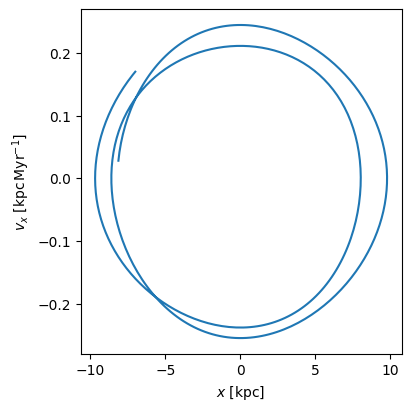

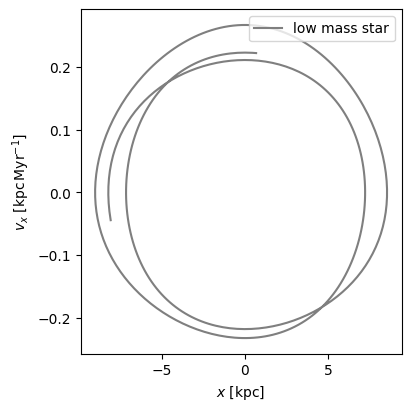

In [38]:
fig = orbits_hi[:, 0].plot(['x', 'v_x'],
                           auto_aspect=False,
                           color=hi_mass_color, label="high mass star")
_ =orbits_lo[:, 0].plot(['x', 'v_x'],
                           auto_aspect=False,
                           color=lo_mass_color, label="low mass star")
plt.legend(loc="upper right")

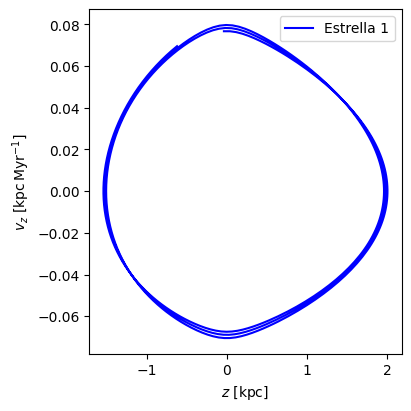

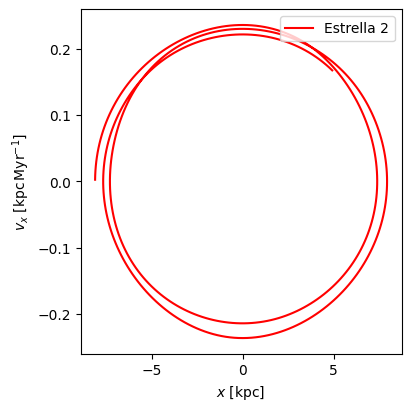

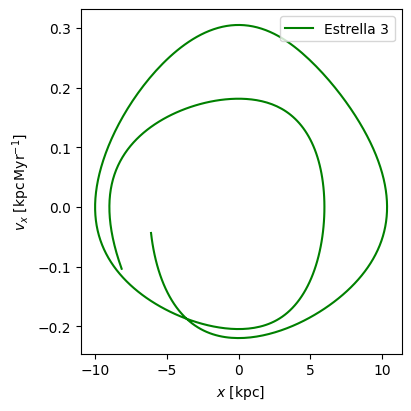

In [39]:
fig = orbits_lo1.plot(['z', 'v_z'],
                           auto_aspect=False,
                           color='b', label="Estrella 1")
plt.legend(loc="upper right")
fig = orbits_lo2.plot(['x', 'v_x'],
                           auto_aspect=False,
                           color='r', label="Estrella 2")
plt.legend(loc="upper right")
fig = orbits_lo3.plot(['x', 'v_x'],
                           auto_aspect=False,
                           color='g', label="Estrella 3")
plt.legend(loc="upper right")

(-0.3, 0.3)

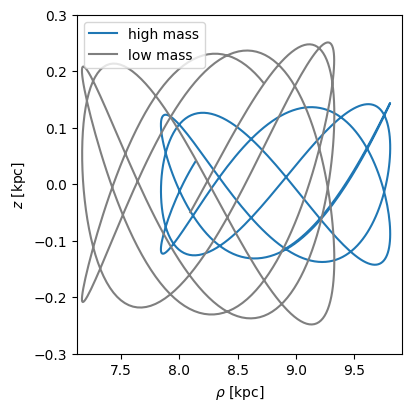

In [40]:
fig = orbits_hi[:, 0].cylindrical.plot(['rho', 'z'],
                                       color=hi_mass_color,
                                       label='high mass')
_ = orbits_lo[:, 0].cylindrical.plot(['rho', 'z'], color=lo_mass_color,
                                     axes=fig.axes,
                                     label='low mass')

fig.axes[0].legend(loc='upper left')
fig.axes[0].set_ylim(-0.3, 0.3)

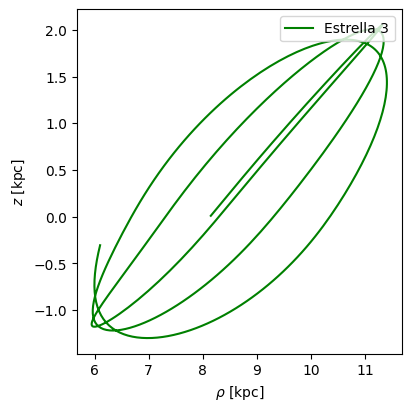

In [41]:
#fig = orbits_lo1.cylindrical.plot(['rho', 'z'], color='b', label="Estrella 1")
#plt.legend(loc="upper right")
#fig = orbits_lo2.cylindrical.plot(['rho', 'z'], color='r', label="Estrella 2")
#plt.legend(loc="upper right")
fig = orbits_lo3.cylindrical.plot(['rho', 'z'], color='g', label="Estrella 3")
plt.legend(loc="upper right")

In [42]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

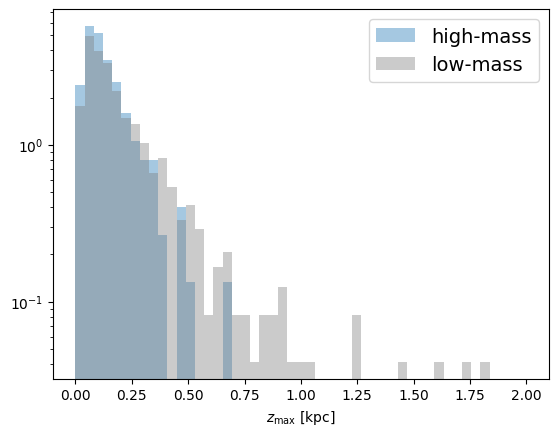

In [43]:
bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins,
         alpha=0.4, density=True, label='high-mass',
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins,
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

In [45]:
for i in range(len(zmax_lo.value)):
  if zmax_lo.value[i]>1.5:
    zmaxnew=zmax_lo.value[i]
    print('Zmax:', zmaxnew)
    print('Posición del array:', i)
    i+=1


#En la posición 240 del array tenemos un zmax mayor 1.5, con valor de 1.75

Zmax: 1.7525778074143998
Posición del array: 240
Zmax: 1.8102662858012013
Posición del array: 296
Zmax: 1.6077903632546187
Posición del array: 479


In [46]:
varexc=np.var(zmax_lo.value)
desvexc=np.sqrt(varexc)
desvexc

np.float64(0.22119330656411842)

In [47]:
promZmaxHM=sum(zmax_hi.value)/len(zmax_hi.value)
promZmaxLM=sum(zmax_lo.value)/len(zmax_lo.value)
promZmaxHM, promZmaxLM


(np.float64(0.15376732675386104), np.float64(0.2105254030554755))

In [48]:
desvZmaxHM=0
for i in range(len(zmax_hi.value)):
  desvZmaxHM += (zmax_hi.value[i]-promZmaxHM)**2
  i+=1
desvEnd=np.sqrt(desvZmaxHM)/(len(zmax_hi.value)-1)
print('La desviación estándar en estrellas de alta masa es', '{:.3f}'.format(desvEnd), 'kpc')


La desviación estándar en estrellas de alta masa es 0.013 kpc


In [49]:
desvZmaxHM=0
for i in range(len(zmax_hi.value)):
  desvZmaxHM += (zmax_hi.value[i]-promZmaxHM)**2
  i+=1
desvEnd=np.sqrt(desvZmaxHM)/(len(zmax_hi.value)-1)
print('La desviación estándar en estrellas de alta masa es', '{:.3f}'.format(desvEnd), 'kpc')


La desviación estándar en estrellas de alta masa es 0.013 kpc


In [50]:
apoc_hi = orbits_hi.apocenter(approximate=True)
apoc_lo = orbits_lo.apocenter(approximate=True)


In [51]:
apoc_lo[479]

<Quantity 11.49868955 kpc>

Text(0.5, 0, '$Apocentro$ [$\\mathrm{kpc}$]')

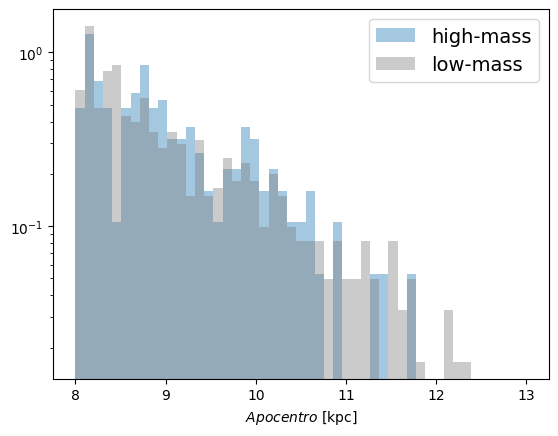

In [52]:
bins = np.linspace(8, 13, 50)

plt.hist(apoc_hi.value, bins=bins,
         alpha=0.4, density=True, label='high-mass',
         color=hi_mass_color)
plt.hist(apoc_lo.value, bins=bins,
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$Apocentro$" + " [{0:latex}]".format(apoc_hi.unit))

In [53]:
excen_hi = orbits_hi.eccentricity(approximate=True)
excen_lo = orbits_lo.eccentricity(approximate=True)

In [54]:
vare=np.var(excen_lo.value)
desve=np.sqrt(vare)
desve

np.float64(0.07374495097098471)

In [55]:
excen_lo[479]

<Quantity 0.31064359>

In [56]:
promExHM=sum(excen_hi)/len(excen_hi)
promExHM
promExLM=sum(excen_lo)/len(excen_lo)
promExLM

<Quantity 0.12218213>

Text(0.5, 0, '$\\epsilon$')

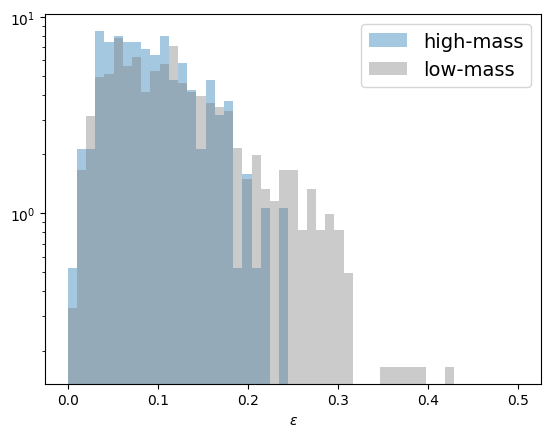

In [57]:
bins = np.linspace(0, 0.5, 50)

plt.hist(excen_hi.value, bins=bins,
         alpha=0.4, density=True, label='high-mass',
         color=hi_mass_color)
plt.hist(excen_lo.value, bins=bins,
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$\epsilon$")

In [58]:
perice_hi = orbits_hi.pericenter(approximate=True)
perice_lo = orbits_lo.pericenter(approximate=True)

In [59]:
perice_lo[479]

<Quantity 6.04794112 kpc>

Text(0.5, 0, '$Pericentro$ [$\\mathrm{kpc}$]')

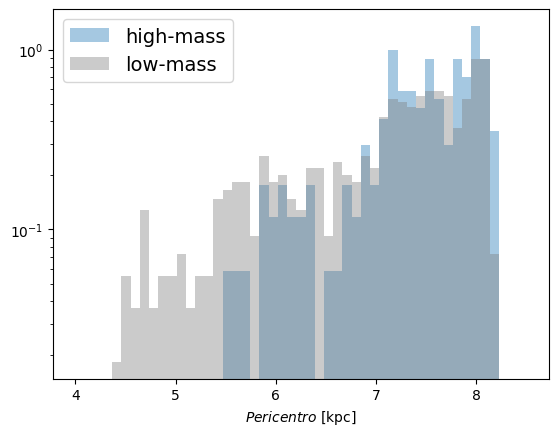

In [60]:
bins = np.linspace(4, 8.5, 50)

plt.hist(perice_hi.value, bins=bins,
         alpha=0.4, density=True, label='high-mass',
         color=hi_mass_color)
plt.hist(perice_lo.value, bins=bins,
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$Pericentro$" + " [{0:latex}]".format(perice_hi.unit))

In [61]:
v1=sum(apoc_hi)/len(apoc_hi)
v2=sum(perice_hi)/len(perice_hi)
v3=(v1+v2)/2
v3

v4=sum(apoc_lo)/len(apoc_lo)
v5=sum(perice_lo)/len(perice_lo)
v6=(v4+v5)/2
v6

desvVtanHM=0
for i in range(len(zmax_hi.value)):
  desvZmaxHM += (zmax_hi.value[i]-promZmaxHM)**2
  i+=1
desvEnd=np.sqrt(desvZmaxHM)/(len(zmax_hi.value)-1)
print('La desviación estándar en estrellas de alta masa es', '{:.3f}'.format(desvEnd), 'kpc')

d2=(apoc_lo+perice_lo)/2
d1=(apoc_hi+perice_hi)/2

varHM=np.var(d1)
varLM=np.var(d2)
desvHM=np.sqrt(varHM)
desvLM=np.sqrt(varLM)
desvHM, desvLM


La desviación estándar en estrellas de alta masa es 0.018 kpc


(<Quantity 0.56514977 kpc>, <Quantity 0.71014581 kpc>)